# 2D & 3D Textual Embedding Visualizations

## Install Dependencies

In [3]:
!pip install transformers datasets wordcloud umap-learn



##1. Dataset of Textual Embeddings

In [4]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [5]:
type(imdb_dataset)

datasets.dataset_dict.DatasetDict

In [6]:
print(f"{len(imdb_dataset['train'])} training examples")
print(f"{len(imdb_dataset['test'])} testing examples")


25000 training examples
25000 testing examples


In [7]:
print(f"{imdb_dataset['train'][0]['text']}")
print(f"{imdb_dataset['train'][0]['label']}")

I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, eve

## 2. Word Cloud

In [8]:
import pandas as pd

imdb_df = pd.DataFrame(imdb_dataset['train'])

In [9]:
imdb_df.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [10]:
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

nb_elements = 100

neg_reviews_list = imdb_df[imdb_df['label'] == 0]['text'][:nb_elements]
neg_reviews_text = " ".join(neg_reviews_list)

pos_reviews_list = imdb_df[imdb_df['label'] == 1]['text'][:nb_elements]
pos_reviews_text = " ".join(pos_reviews_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


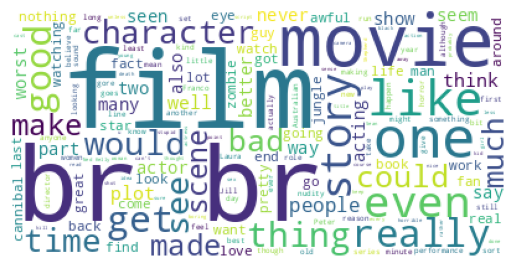

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', stopwords = stopwords.words('english'), max_words = 200).generate(neg_reviews_text)
fig = plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('neg_reviews_wordcloud.png')
plt.show()



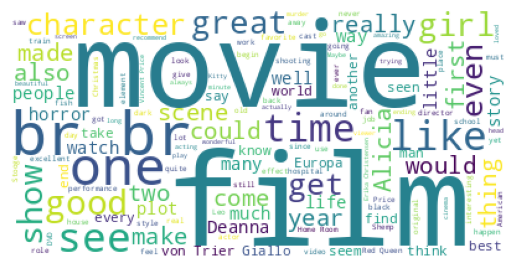

In [12]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', stopwords = stopwords.words('english'), max_words = 200).generate(pos_reviews_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('pos_reviews_wordcloud.png')
plt.show()

##3. Textual Embeddings Generation

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch


# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Tokenize sentences
encoded_input_pos_reviews = tokenizer(pos_reviews_list.to_list(), padding=True, truncation=True, return_tensors='pt')
encoded_input_neg_reviews = tokenizer(neg_reviews_list.to_list(), padding=True, truncation=True, return_tensors='pt')


# Compute token embeddings
with torch.no_grad():
    model_output_pos_reviews = model(**encoded_input_pos_reviews)
    model_output_neg_reviews = model(**encoded_input_neg_reviews)


# Perform pooling. In this case, max pooling.
sentence_embeddings_pos_reviews = mean_pooling(model_output_pos_reviews, encoded_input_pos_reviews['attention_mask'])
sentence_embeddings_neg_reviews = mean_pooling(model_output_neg_reviews, encoded_input_neg_reviews['attention_mask'])


print(f"Sentence embeddings for Pos Reviews: {sentence_embeddings_pos_reviews.shape}:")
print(f"Sentence embeddings for Neg Reviews: {sentence_embeddings_neg_reviews.shape}:")


tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Sentence embeddings for Pos Reviews: torch.Size([100, 384]):
Sentence embeddings for Neg Reviews: torch.Size([100, 384]):


##4. Dimension Reduction

In [ ]:
import umap

reducer_2d = umap.UMAP(n_components=2)
pos_reviews_2d = reducer_2d.fit_transform(sentence_embeddings_pos_reviews)
neg_reviews_2d = reducer_2d.fit_transform(sentence_embeddings_neg_reviews)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
import numpy as np

pos_reviews_2d_df = pd.DataFrame(pos_reviews_2d[:, :2], columns=['x', 'y'])
neg_reviews_2d_df = pd.DataFrame(neg_reviews_2d[:, :2], columns=['x', 'y'])

pos_reviews_2d_df['label'] = 'Positive'
neg_reviews_2d_df['label'] = 'Negative'

pos_reviews_2d_df = pd.concat([pos_reviews_2d_df, neg_reviews_2d_df], axis=0)

In [ ]:
pos_reviews_2d_df

,x,y,label
0,9.719003,4.169020,Positive
1,9.766123,3.993029,Positive
2,13.679660,7.039374,Positive
3,13.601428,7.183446,Positive
4,13.677113,7.383374,Positive
...,...,...,...
95,12.301525,1.145365,Negative
96,10.803057,2.722303,Negative
97,10.294213,5.366035,Negative
98,13.131324,1.754215,Negative


In [ ]:
reducer_3d = umap.UMAP(n_components=3)
pos_reviews_3d = reducer_3d.fit_transform(sentence_embeddings_pos_reviews)
neg_reviews_3d = reducer_3d.fit_transform(sentence_embeddings_neg_reviews)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
pos_reviews_3d_df = pd.DataFrame(pos_reviews_3d[:, :3], columns=['x', 'y', 'z'])
neg_reviews_3d_df = pd.DataFrame(neg_reviews_3d[:, :3], columns=['x', 'y', 'z'])

pos_reviews_3d_df['label'] = 'Positive'
neg_reviews_3d_df['label'] = 'Negative'

pos_reviews_3d_df = pd.concat([pos_reviews_3d_df, neg_reviews_3d_df], axis=0)

In [ ]:
pos_reviews_3d_df

,x,y,z,label
0,12.231090,12.072061,5.143354,Positive
1,12.094809,12.249235,4.895133,Positive
2,13.305998,13.271811,9.693255,Positive
3,13.160034,12.988665,9.646761,Positive
4,13.053036,13.437503,9.365933,Positive
...,...,...,...,...
95,7.257244,-0.540467,14.957626,Negative
96,7.518081,-0.105768,13.023604,Negative
97,7.312713,0.391263,10.771982,Negative
98,6.120812,-0.361076,14.641256,Negative


##5. Visualization

In [ ]:
import plotly.express as px

fig = px.scatter(pos_reviews_2d_df, x='x', y='y', color='label', trendline='ols')
fig.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(pos_reviews_3d_df, x='x', y='y', z='z', color='label')
fig.show()
